In [1]:
# Importing libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import sklearn.linear_model as linear_model
from sklearn.linear_model import Lasso
from scipy import stats
from xgboost import XGBRegressor # 부스팅-XGBoost회귀
from lightgbm import LGBMRegressor # 부스팅-LightGBM 회귀
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score
import warnings         # warnings : 버전 충돌 및 특정 예외 처리를 위해 불러온 내장 모듈
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 1. EDA

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [4]:
# 수치형 변수

train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


## 독립변수, 종속변수 정리

- Feature(X, 독립 변수)

    1. id - 고유id
    1. hour - 시간
    1. temperature - 기온
    1. precipitation - 비가 오지 않았으면 0, 비가 왔으면 1
    1. windspeed - 풍속
    1. humidity - 습도
    1. visibility - 가시성
    1 .ozone - 오존
    1 .pm10 - 미세먼지
    1. pm2.5 - 미세먼지

    

- Target

    1. count = 시간당 따릉이 대여 수

In [5]:
train.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [7]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [8]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Value Ratio' :train_na})
missing_data.head(20)

,Missing Value Ratio
hour_bef_pm2.5,8.019191
hour_bef_pm10,6.168609
hour_bef_ozone,5.209047
hour_bef_windspeed,0.616861
hour_bef_visibility,0.137080
hour_bef_humidity,0.137080
hour_bef_precipitation,0.137080
hour_bef_temperature,0.137080


Text(0.5, 1.0, 'Ratio of missing values')

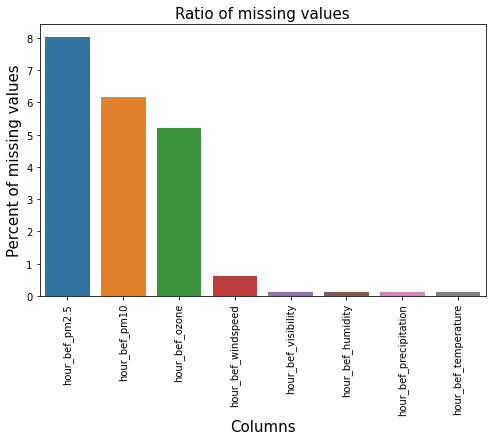

In [9]:
f, ax = plt.subplots(figsize=(8, 5))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Columns', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Ratio of missing values', fontsize=15)

# 2. 데이터 전처리

## 2-1. 결측치 처리

In [10]:
train['hour_bef_pm2.5'].describe()

count    1342.000000
mean       30.327124
std        14.713252
min         8.000000
25%        20.000000
50%        26.000000
75%        37.000000
max        90.000000
Name: hour_bef_pm2.5, dtype: float64

In [11]:
# 분포에 맞는 난수를 생성하여 결측치 처리.

import numpy as np

mean = train['hour_bef_pm2.5'].mean()        # age 의 mean 값을 구함
std =  train['hour_bef_pm2.5'].std()        # age 의 std 값을 구함
size = train['hour_bef_pm2.5'].isna().sum()        # age 에 nan 값이 몇개인지를 구함 


rand_pm2 = np.random.randint(mean-std, mean+std, size)    # mean 에서 std 만큼 떨어져 있는 랜덤한 값들을 size 만큼 반환

print(rand_pm2)

[27 32 44 43 36 44 28 35 37 21 32 26 42 30 16 36 24 37 37 22 29 26 36 27
 31 33 28 42 25 37 42 16 44 36 17 26 37 23 27 44 34 16 19 22 18 16 29 42
 40 22 44 40 15 37 19 18 40 37 20 25 25 44 33 24 39 24 22 21 21 36 31 42
 40 42 22 30 25 17 36 43 43 22 32 39 31 31 34 38 17 18 27 36 23 17 20 16
 26 25 44 37 44 40 22 29 38 18 31 21 33 17 38 33 31 31 24 36 33]


In [12]:
# 기존 'Age'열 중 비어있는 값에 난수생성으로 만든 rand_age를 차례로 넣기

train['hour_bef_pm2.5'].loc[train['hour_bef_pm2.5'].isna()] = rand_pm2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
train['hour_bef_pm10'].describe()

count    1369.000000
mean       57.168736
std        31.771019
min         9.000000
25%        36.000000
50%        51.000000
75%        69.000000
max       269.000000
Name: hour_bef_pm10, dtype: float64

In [14]:
# 분포에 맞는 난수를 생성하여 결측치 처리.

import numpy as np

mean = train['hour_bef_pm10'].mean()        # age 의 mean 값을 구함
std =  train['hour_bef_pm10'].std()        # age 의 std 값을 구함
size = train['hour_bef_pm10'].isna().sum()        # age 에 nan 값이 몇개인지를 구함 


rand_pm10 = np.random.randint(mean-std, mean+std, size)    # mean 에서 std 만큼 떨어져 있는 랜덤한 값들을 size 만큼 반환

print(rand_pm10)

[69 30 26 45 35 85 29 49 66 64 39 53 56 72 80 87 70 28 31 51 50 70 79 53
 66 58 79 47 34 27 39 34 81 52 48 86 75 31 35 52 61 56 44 70 55 82 42 37
 38 46 69 27 51 55 69 74 40 29 52 47 63 28 73 40 75 57 26 31 31 30 42 28
 33 25 82 73 85 76 71 37 79 52 60 38 86 55 30 49 53 80]


In [15]:
# 기존 'Age'열 중 비어있는 값에 난수생성으로 만든 rand_age를 차례로 넣기

train['hour_bef_pm10'].loc[train['hour_bef_pm10'].isna()] = rand_pm10

In [16]:
train['hour_bef_ozone'].describe()

count    1383.000000
mean        0.039149
std         0.019509
min         0.003000
25%         0.025500
50%         0.039000
75%         0.052000
max         0.125000
Name: hour_bef_ozone, dtype: float64

In [17]:
# 기존 'Age'열 중 비어있는 값에 난수생성으로 만든 rand_age를 차례로 넣기

train['hour_bef_ozone'] = train['hour_bef_ozone'].fillna(0.039)

In [18]:
train['hour_bef_windspeed'].describe()

count    1450.000000
mean        2.479034
std         1.378265
min         0.000000
25%         1.400000
50%         2.300000
75%         3.400000
max         8.000000
Name: hour_bef_windspeed, dtype: float64

In [19]:
train['hour_bef_windspeed'] = train['hour_bef_windspeed'].fillna(1.4)

In [20]:
train['hour_bef_visibility'].describe()

count    1457.000000
mean     1405.216884
std       583.131708
min        78.000000
25%       879.000000
50%      1577.000000
75%      1994.000000
max      2000.000000
Name: hour_bef_visibility, dtype: float64

In [21]:
train['hour_bef_visibility'] = train['hour_bef_visibility'].fillna(1405)

In [22]:
train['hour_bef_humidity'].describe()

count    1457.000000
mean       52.231297
std        20.370387
min         7.000000
25%        36.000000
50%        51.000000
75%        69.000000
max        99.000000
Name: hour_bef_humidity, dtype: float64

In [23]:
train['hour_bef_humidity'] = train['hour_bef_humidity'].fillna(52)

In [24]:
train['hour_bef_precipitation'].value_counts()

0.0    1411
1.0      46
Name: hour_bef_precipitation, dtype: int64

In [25]:
train['hour_bef_precipitation'] = train['hour_bef_precipitation'].fillna(0)

In [26]:
train['hour_bef_temperature'].describe()

count    1457.000000
mean       16.717433
std         5.239150
min         3.100000
25%        12.800000
50%        16.600000
75%        20.100000
max        30.000000
Name: hour_bef_temperature, dtype: float64

In [27]:
train['hour_bef_temperature'] = train['hour_bef_temperature'].fillna(16)

In [28]:
# 모든 결측치 처리 완료

train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Value Ratio' :train_na})
missing_data.head(20)

,Missing Value Ratio


## 2-2. 변수별 시각화 및 전처리 방식 결정

#### count (target 변수)

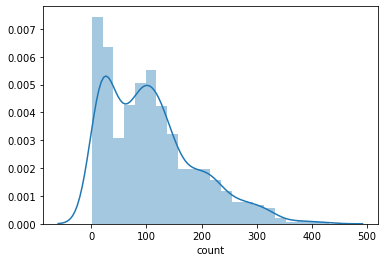

In [29]:
# 전처리 x

sns.distplot(train['count']);

#### 습도(비 o,x)

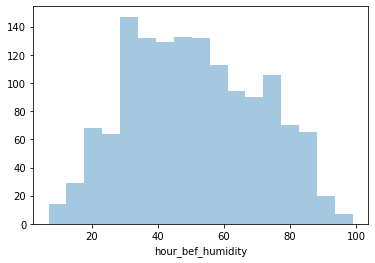

In [30]:
sns.distplot(train.hour_bef_humidity.loc[train['hour_bef_precipitation'] == 0], kde = False)

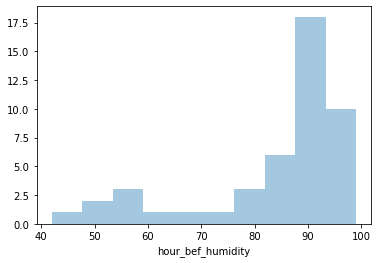

In [31]:
sns.distplot(train.hour_bef_humidity.loc[train['hour_bef_precipitation'] == 1], kde = False)

#### 가시성(비 o,x)

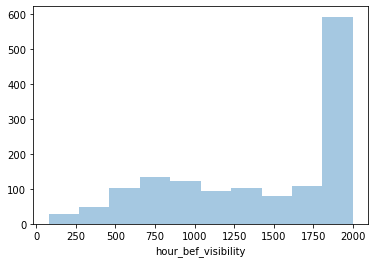

In [32]:
sns.distplot(train.hour_bef_visibility.loc[train['hour_bef_precipitation'] == 0], kde = False)

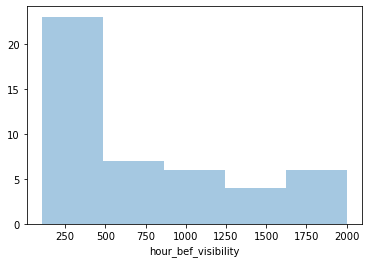

In [33]:
sns.distplot(train.hour_bef_visibility.loc[train['hour_bef_precipitation'] == 1], kde = False)

#### 오존

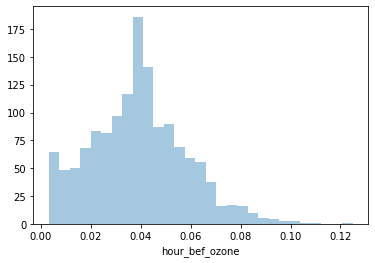

In [34]:
sns.distplot(train.hour_bef_ozone.loc[train['hour_bef_precipitation'] == 0], kde = False)

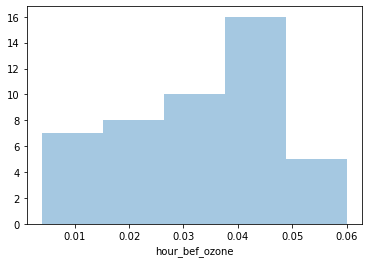

In [35]:
sns.distplot(train.hour_bef_ozone.loc[train['hour_bef_precipitation'] == 1], kde = False)

In [36]:
# 오존은 값도 범위가 작고, 크게 영향X. 따라서 드랍.

In [37]:
train.drop('hour_bef_ozone', axis=1, inplace = True)
train.shape

(1459, 10)

#### 미세먼지

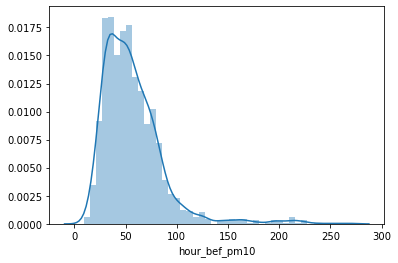

In [38]:
sns.distplot(train['hour_bef_pm10']);

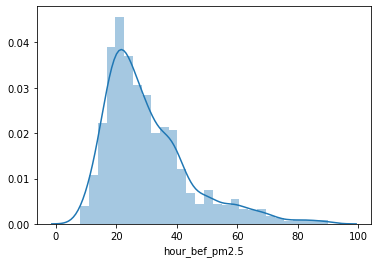

In [39]:
sns.distplot(train['hour_bef_pm2.5']);

In [40]:
# 미세먼지 크기별 분포의 형태가 같기때문에 두개를 더한후 하나의 변수로 만들기

train['hour_bef_pm'] = train['hour_bef_pm10'] + train['hour_bef_pm2.5']
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_pm10,hour_bef_pm2.5,count,hour_bef_pm
0,3,20,16.3,1.0,1.5,89.0,576.0,76.0,33.0,49.0,109.0
1,6,13,20.1,0.0,1.4,48.0,916.0,73.0,40.0,159.0,113.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,32.0,19.0,26.0,51.0
3,8,23,8.1,0.0,2.7,54.0,946.0,75.0,64.0,57.0,139.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,27.0,11.0,431.0,38.0


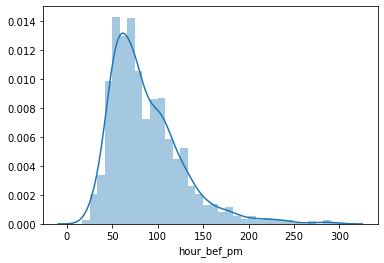

In [41]:
sns.distplot(train['hour_bef_pm']);

In [42]:
# 미세먼지 2.5, 10 변수 제거

train.drop(['hour_bef_pm10','hour_bef_pm2.5'], axis=1, inplace = True)
train.shape

(1459, 9)

#### 풍속(비 o,x)

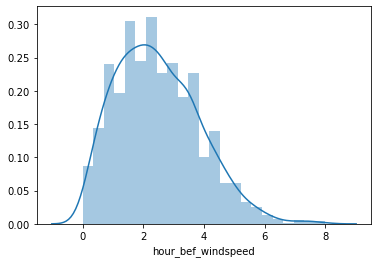

In [43]:
sns.distplot(train['hour_bef_windspeed']);

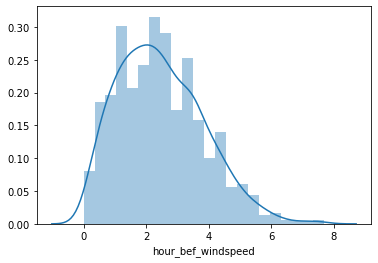

In [44]:
sns.distplot(train.hour_bef_windspeed.loc[train['hour_bef_precipitation'] == 0], kde = True)

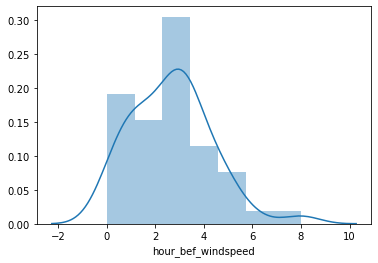

In [45]:
sns.distplot(train.hour_bef_windspeed.loc[train['hour_bef_precipitation'] == 1], kde = True)

#### 온도(비 o,x)

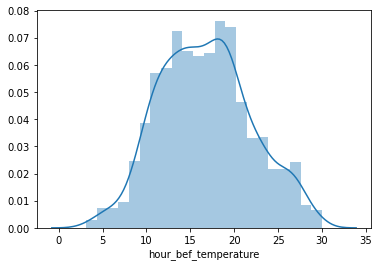

In [46]:
sns.distplot(train['hour_bef_temperature']);

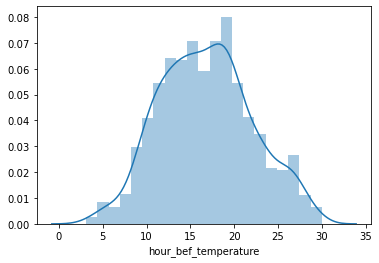

In [47]:
sns.distplot(train.hour_bef_temperature.loc[train['hour_bef_precipitation'] == 0], kde = True)

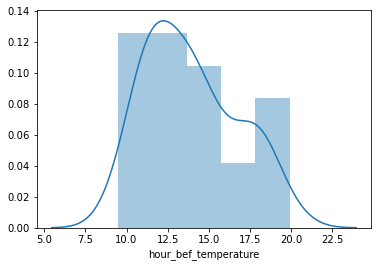

In [48]:
sns.distplot(train.hour_bef_temperature.loc[train['hour_bef_precipitation'] == 1], kde = True)

#### 시간대별 대여 수

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

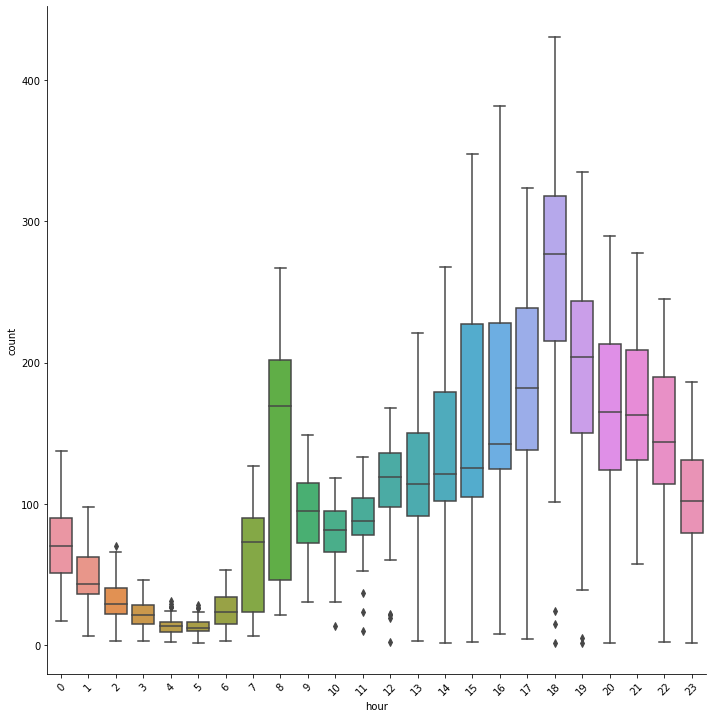

In [49]:
sns.catplot(y = 'count', x = 'hour', data = train, kind = 'box', height = 10)
plt.xticks(rotation = 45)

#### 대여수 박스플롯비교(비 o,x)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

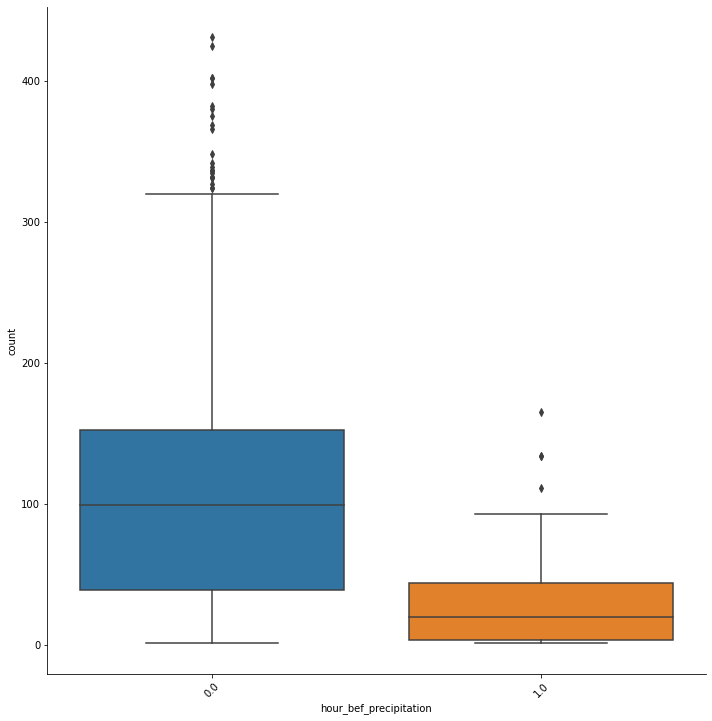

In [50]:
sns.catplot(y = 'count', x = 'hour_bef_precipitation', data = train, kind = 'box', height = 10)
plt.xticks(rotation = 45)

In [51]:
# 비 o,x 더미변수로 나누기.

df1 = pd.get_dummies(train['hour_bef_precipitation'], prefix = 'precipitation_' ,drop_first=False)
train = pd.concat([train, df1], axis=1 )
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,count,hour_bef_pm,precipitation__0.0,precipitation__1.0
0,3,20,16.3,1.0,1.5,89.0,576.0,49.0,109.0,0,1
1,6,13,20.1,0.0,1.4,48.0,916.0,159.0,113.0,1,0
2,7,6,13.9,0.0,0.7,79.0,1382.0,26.0,51.0,1,0
3,8,23,8.1,0.0,2.7,54.0,946.0,57.0,139.0,1,0
4,9,18,29.5,0.0,4.8,7.0,2000.0,431.0,38.0,1,0


In [52]:
train.drop('hour_bef_precipitation', axis=1, inplace = True)
train.shape

(1459, 10)

In [54]:
train.drop('id', axis = 1, inplace=True)
train.head()

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,count,hour_bef_pm,precipitation__0.0,precipitation__1.0
0,20,16.3,1.5,89.0,576.0,49.0,109.0,0,1
1,13,20.1,1.4,48.0,916.0,159.0,113.0,1,0
2,6,13.9,0.7,79.0,1382.0,26.0,51.0,1,0
3,23,8.1,2.7,54.0,946.0,57.0,139.0,1,0
4,18,29.5,4.8,7.0,2000.0,431.0,38.0,1,0


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1459 non-null   int64  
 1   hour                  1459 non-null   int64  
 2   hour_bef_temperature  1459 non-null   float64
 3   hour_bef_windspeed    1459 non-null   float64
 4   hour_bef_humidity     1459 non-null   float64
 5   hour_bef_visibility   1459 non-null   float64
 6   count                 1459 non-null   float64
 7   hour_bef_pm           1459 non-null   float64
 8   precipitation__0.0    1459 non-null   uint8  
 9   precipitation__1.0    1459 non-null   uint8  
dtypes: float64(6), int64(2), uint8(2)
memory usage: 94.2 KB


## 전처리 완료

# 3. 모델링

In [55]:
y = train['count']
y.shape

(1459,)

In [56]:
X = train.drop('count', axis=1)
X.shape

(1459, 8)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1167, 8)
(292, 8)
(1167,)
(292,)


In [59]:
def test_model(model, X_train, y_train):
    cv = KFold(n_splits = 10, shuffle=True)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, X_train, y_train, cv=cv, scoring = r2, n_jobs=-1)
    score = [r2_val_score.mean()]
    return score

In [60]:
def rsme(model, X, y):
    cv_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    return np.sqrt(cv_scores)

### Lasso회귀를 이용하여 유의미한 변수파악

In [61]:
## Tuning parameters

param_grid = {'alpha':[0.0001,0.001,0.01,1.,5.,10.,25.],'max_iter':[50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Home in
param_grid = {'alpha':[x/100. * alpha for x in range(50,150,5)],'max_iter':[50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('Lasso -> Train RSME: {:,.5f}| alpha {:,.5f}'.format(rsme(lasso, X_train, y_train).mean(),alpha))

Lasso -> Train RSME: 52.89914| alpha 0.01450


In [62]:
dfColumns = X_train.columns

Lasso dropped 0 of 8 features.


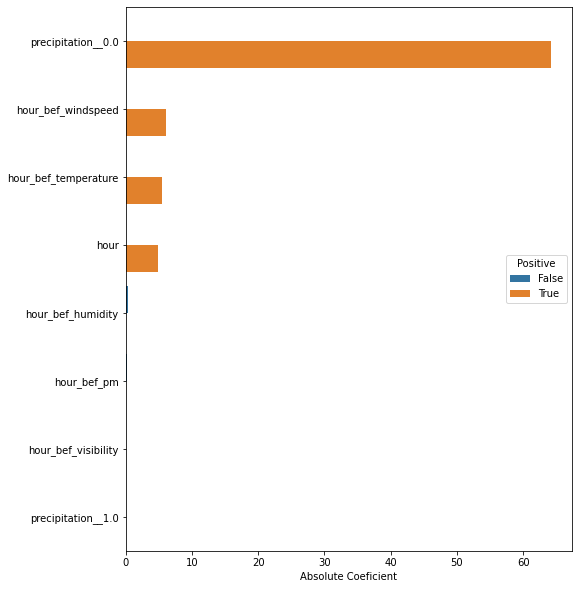

In [63]:
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_>0}, index=dfColumns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Lasso dropped {} of {} features.'.format(sum(coefs.coefs==0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10) # 상위 10개 유의미한 변수
plt.figure(figsize=(8,10))
sns.barplot(top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title=('Lasso Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

In [64]:
# 상위 10개 유의미한 변수

top_coefs

,coefs,Positive,coefs_abs
precipitation__0.0,6.414301e+01,True,6.414301e+01
hour_bef_windspeed,6.113444e+00,True,6.113444e+00
hour_bef_temperature,5.509353e+00,True,5.509353e+00
hour,4.861738e+00,True,4.861738e+00
hour_bef_humidity,-4.026422e-01,False,4.026422e-01
hour_bef_pm,-2.599275e-01,False,2.599275e-01
hour_bef_visibility,-3.210739e-03,False,3.210739e-03
precipitation__1.0,-2.048882e-13,False,2.048882e-13


In [65]:
# Linear Regression

LR = linear_model.LinearRegression(n_jobs=-1)
acc_LR = test_model(LR, X_train, y_train)

LR_rsme = rsme(LR, X_train, y_train)

print('Score: {:.5f}'.format((acc_LR[0])))
print('RSME: {:.5f}'.format(LR_rsme.mean()))

Score: 0.58598
RSME: 52.89983


In [66]:
# Support Vector Regressor

svr_reg = SVR(kernel='rbf')
acc_SVR = test_model(svr_reg, X_train, y_train)

svr_rsme = rsme(svr_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_SVR[0])))
print('RSME: {:.5f}'.format(svr_rsme.mean()))

Score: 0.04459
RSME: 80.43802


In [67]:
#Decision Tree
dt_reg = DecisionTreeRegressor(random_state=21)
acc_tree = test_model(dt_reg, X_train, y_train)

dt_rsme = rsme(dt_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_tree[0])))
print('RSME: {:.5f}'.format(dt_rsme.mean()))

Score: 0.55881
RSME: 54.05348


In [68]:
# Random Forest
rf_reg = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
acc_rf = test_model(rf_reg, X_train, y_train)

rf_rsme = rsme(rf_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_rf[0])))
print('RSME: {:.5f}'.format(rf_rsme.mean()))

Score: 0.76982
RSME: 38.14555


In [69]:
# Bagging Regressor
br_reg = BaggingRegressor(n_estimators=1000, n_jobs=-1)
acc_br = test_model(br_reg, X_train, y_train)

br_rsme = rsme(br_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_br[0])))
print('RSME: {:.5f}'.format(br_rsme.mean()))

Score: 0.78218
RSME: 38.05748


In [70]:
# Gradient Boosting Regressor
gbr_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, loss='ls')
acc_gbr = test_model(gbr_reg, X_train, y_train)

gbr_rsme = rsme(gbr_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_gbr[0])))
print('RSME: {:.5f}'.format(gbr_rsme.mean()))

Score: 0.76902
RSME: 39.82429


In [71]:
# XGBoost

xgb_reg = xgb.XGBRegressor()

acc_xgb = test_model(xgb_reg, X_train[top_coefs.index], y_train)
xgb_rsme = rsme(xgb_reg, X_train[top_coefs.index], y_train)

print('Score: {:.5f}'.format((acc_xgb[0])))
print('RSME: {:.5f}'.format(xgb_rsme.mean()))

Score: 0.76077
RSME: 39.12618


In [72]:
# Ligth GBM

lgb_reg = LGBMRegressor()

acc_lgb = test_model(lgb_reg, X_train[top_coefs.index], y_train)
lgb_rsme = rsme(lgb_reg, X_train[top_coefs.index], y_train)

print('Score: {:.5f}'.format((acc_lgb[0])))
print('RSME: {:.5f}'.format(lgb_rsme.mean()))

Score: 0.77434
RSME: 38.57915


In [73]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Regressor', 
              'Decision Tree', 'Random Forest', 'Bagging Regressor', 'Gradient Boosting Regressor ','XGBoost','Light GBM'],
    'Score': [acc_LR[0], acc_SVR[0], acc_tree[0], acc_rf[0], acc_br[0], acc_gbr[0], acc_xgb[0], acc_lgb[0]],
    'RSME': [LR_rsme.mean(), svr_rsme.mean(), dt_rsme.mean(), rf_rsme.mean(), br_rsme.mean(), gbr_rsme.mean(), 
             xgb_rsme.mean(), lgb_rsme.mean()],
    'RMSE_std':[LR_rsme.std(), svr_rsme.std(), dt_rsme.std(), rf_rsme.std(), br_rsme.std(), gbr_rsme.std(), 
                xgb_rsme.std(), lgb_rsme.std()]
})

result = results.sort_values(by='RSME', ascending=True)
result = result.set_index('Model')
display(result.head(9))

,Score,RSME,RMSE_std
Model,,,
Bagging Regressor,0.782179,38.057475,5.134619
Random Forest,0.769819,38.145555,5.169938
Light GBM,0.774344,38.579148,5.197582
XGBoost,0.760766,39.126184,4.631694
Gradient Boosting Regressor,0.769016,39.824294,5.286592
Linear Regression,0.585976,52.899829,4.937410
Decision Tree,0.558814,54.053484,5.762346
Support Vector Regressor,0.044590,80.438020,5.928409


# 4. 하이퍼파라미터 튜닝

## 4-1. 랜덤 포레스트 (RandomizedSearchCV)

In [74]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)

# Minimum number of samples required to split a node

min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node

min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree

bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [75]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [77]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=100, n_estimators=600)

In [78]:
rf_best = RandomForestRegressor(max_depth=100, n_estimators=600, n_jobs=-1)

In [79]:
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=600, n_jobs=-1)

In [80]:
acc_rf_best = test_model(rf_best, X_train, y_train)
rf_best_rsme = rsme(rf_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_rf_best[0])))
print('RSME: {:.5f}'.format(rf_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(rf_best_rsme.std()))

Score: 0.77632
RSME: 38.20863
RSME_std: 4.99932


## 4-2. Light GBM(RandomizedSearchCV)

In [92]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 120, num = 20)]

max_depth.append(None)

# Minimum number of samples required to split a node

min_samples_split = [3,6,9,10]

# Minimum number of samples required at each leaf node

min_samples_leaf = [ 1, 3, 6, 9 ]

# Method of selecting samples for training each tree

bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 119, 138, 157, 176, 195, 215, 234, 253, 272, 291, 311, 330, 349, 368, 387, 407, 426, 445, 464, 483, 503, 522, 541, 560, 579, 598, 618, 637, 656, 675, 694, 714, 733, 752, 771, 790, 810, 829, 848, 867, 886, 906, 925, 944, 963, 982, 1002, 1021, 1040, 1059, 1078, 1097, 1117, 1136, 1155, 1174, 1193, 1213, 1232, 1251, 1270, 1289, 1309, 1328, 1347, 1366, 1385, 1405, 1424, 1443, 1462, 1481, 1501, 1520, 1539, 1558, 1577, 1596, 1616, 1635, 1654, 1673, 1692, 1712, 1731, 1750, 1769, 1788, 1808, 1827, 1846, 1865, 1884, 1904, 1923, 1942, 1961, 1980, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 21, 27, 33, 38, 44, 50, 56, 62, 67, 73, 79, 85, 91, 96, 102, 108, 114, 120, None], 'min_samples_split': [3, 6, 9, 10], 'min_samples_leaf': [1, 3, 6, 9], 'bootstrap': [True, False]}


In [93]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

lg_cl = LGBMRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

lg_random = RandomizedSearchCV(estimator = lg_cl, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model

lg_random.fit(X_train, y_train)
print(lg_random.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.4s


LGBMRegressor(bootstrap=True, max_depth=44, max_features='auto',
              min_samples_leaf=1, min_samples_split=10)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   51.4s finished


In [94]:
lg_random.best_estimator_

LGBMRegressor(bootstrap=True, max_depth=44, max_features='auto',
              min_samples_leaf=1, min_samples_split=10)

In [95]:
lg_random_best = LGBMRegressor(bootstrap=True, max_depth=44, max_features='auto',
              min_samples_leaf=1, min_samples_split=10)

In [99]:
acc_lg_random_best = test_model(lg_random_best, X_train, y_train)
lg_random_best_rsme = rsme(lg_random_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_lg_random_best[0])))
print('RSME: {:.5f}'.format(lg_random_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(lg_random_best_rsme.std()))

Score: 0.77821
RSME: 38.57915
RSME_std: 5.19758


## 4-3. Light GBM(Bayesian optimization)

In [178]:
bayes_params = {
    'num_leaves': (4, 99),
    'colsample_bytree':(0.5, 1), 
    'subsample': (0.5, 1),
    'max_depth': (4, 128),
    'reg_alpha': (0, 0.9),
    'reg_lambda': (0, 0.9), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(1, 99)
}

In [187]:
from sklearn.metrics import mean_squared_error

def lgb_rmse_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    params = {
        "n_estimator":500,
        "learning_rate":0.05,
        'num_leaves': int(round(num_leaves)),
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbosity': -1
    }
    print("params:", params)
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="rmse", verbose=10)
    best_iter = lgb_model.best_iteration_
    print('best_iter:', best_iter)
    
    y_preds = lgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse) 

    print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
    print('Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)')
    print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))
    return rmse
    
    

In [188]:
from bayes_opt import BayesianOptimization

BO_lgb = BayesianOptimization(lgb_rmse_eval, bayes_params)

In [189]:
BO_lgb.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
params: {'n_estimator': 500, 'learning_rate': 0.05, 'num_leaves': 33, 'colsample_bytree': 0.9840560097981954, 'subsample': 0.5433821348549988, 'max_depth': 96, 'reg_alpha': 0.558045651207485, 'reg_lambda': 0.7326806085306032, 'min_split_gain': 0.03189611970699496, 'min_child_weight': 6.694719278426128, 'verbosity': -1}
[10]	valid_0's rmse: 61.0321	valid_0's l2: 3724.92
[20]	valid_0's rmse: 50.5917	valid_0's l2: 2559.52
[30]	valid_0's rmse: 46.2054	valid_0's l2: 2134.94
[40]	valid_0's rmse: 44.4937	valid_0's l2: 1979.69
[50]	valid_0's rmse: 43.7839	valid_0's l2: 1917.03
[60]	valid_0's rmse: 43.6866	valid_0's l2: 1908.52
[70]	valid_0's rmse: 43.7333	valid_0's l2: 1912.6
[80]	valid_0's rmse: 43.6663	valid_0's l2: 1906.74
[90]	valid_0's rmse: 43.7116

[70]	valid_0's rmse: 41.6747	valid_0's l2: 1736.78
[80]	valid_0's rmse: 41.7245	valid_0's l2: 1740.94
[90]	valid_0's rmse: 41.7594	valid_0's l2: 1743.84
[100]	valid_0's rmse: 41.7068	valid_0's l2: 1739.46
best_iter: None
MSE : 1739.461 , RMSE : 41.707
Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)
Variance score : 0.739
|  8        |  41.71    |  0.6233   |  98.05    |  6.061    |  0.06341  |  34.23    |  0.4978   |  0.6594   |  0.5183   |
params: {'n_estimator': 500, 'learning_rate': 0.05, 'num_leaves': 80, 'colsample_bytree': 0.7170504051754711, 'subsample': 0.8640145245702969, 'max_depth': 123, 'reg_alpha': 0.03558518582914279, 'reg_lambda': 0.44923139484514524, 'min_split_gain': 0.0035511399620837564, 'min_child_weight': 93.59412895281072, 'verbosity': -1}
[10]	valid_0's rmse: 65.1932	valid_0's l2: 4250.15
[20]	valid_0's rmse: 55.3269	valid_0's l2: 3061.07
[30]	valid_0's rmse: 49.4754	valid_0's l2: 2447.82
[40]	valid_0's rmse: 46.1814	valid_0's l2: 2132.72
[50]	valid_0's rmse: 44.03

In [190]:
BO_lgb.res

[{'target': 43.797586854872016,
  'params': {'colsample_bytree': 0.9840560097981954,
   'max_depth': 96.2345156225822,
   'min_child_weight': 6.694719278426128,
   'min_split_gain': 0.03189611970699496,
   'num_leaves': 32.92776952366905,
   'reg_alpha': 0.558045651207485,
   'reg_lambda': 0.7326806085306032,
   'subsample': 0.5433821348549988}},
 {'target': 41.34463410396713,
  'params': {'colsample_bytree': 0.7113707288879971,
   'max_depth': 22.508516002249756,
   'min_child_weight': 81.87852782213966,
   'min_split_gain': 0.028508872570632844,
   'num_leaves': 77.88390084208908,
   'reg_alpha': 0.8963385694778676,
   'reg_lambda': 0.12277692768899,
   'subsample': 0.7912971108222098}},
 {'target': 41.42504489732053,
  'params': {'colsample_bytree': 0.8913398778019934,
   'max_depth': 96.29461782277113,
   'min_child_weight': 48.27273697387598,
   'min_split_gain': 0.08656154691252615,
   'num_leaves': 51.934263693889264,
   'reg_alpha': 0.8516242534524245,
   'reg_lambda': 0.865628

In [191]:
BO_lgb.max

{'target': 44.24811417104195,
 'params': {'colsample_bytree': 0.5322052324313045,
  'max_depth': 97.60254519489044,
  'min_child_weight': 8.808455925130891,
  'min_split_gain': 0.08980080006795221,
  'num_leaves': 32.28721276037477,
  'reg_alpha': 0.33167300365673624,
  'reg_lambda': 0.09795425629285077,
  'subsample': 0.9427604735124657}}

In [192]:
max_params = BO_lgb.max['params']

max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['max_depth'] = int(round(max_params['max_depth']))

lgbm_clf_bayes_best = LGBMRegressor(n_estimators=1000, learning_rate=0.001, **max_params)

evals = [(X_test, y_test)]
lightgbmregressor.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="rmse", eval_set=evals,
                verbose=True)

# accuracy score가 아니라 mse 와 rmse 로 확인 0에 가까울 수록 좋다.

y_preds = lightgbmregressor.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)')
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

[1]	valid_0's rmse: 82.2602	valid_0's l2: 6766.75
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 82.229	valid_0's l2: 6761.61
[3]	valid_0's rmse: 82.214	valid_0's l2: 6759.15
[4]	valid_0's rmse: 82.181	valid_0's l2: 6753.72
[5]	valid_0's rmse: 82.1534	valid_0's l2: 6749.18
[6]	valid_0's rmse: 82.1259	valid_0's l2: 6744.66
[7]	valid_0's rmse: 82.0948	valid_0's l2: 6739.55
[8]	valid_0's rmse: 82.0637	valid_0's l2: 6734.45
[9]	valid_0's rmse: 82.0308	valid_0's l2: 6729.05
[10]	valid_0's rmse: 82.0159	valid_0's l2: 6726.61
[11]	valid_0's rmse: 81.9885	valid_0's l2: 6722.12
[12]	valid_0's rmse: 81.9611	valid_0's l2: 6717.63
[13]	valid_0's rmse: 81.9463	valid_0's l2: 6715.2
[14]	valid_0's rmse: 81.9316	valid_0's l2: 6712.78
[15]	valid_0's rmse: 81.9006	valid_0's l2: 6707.71
[16]	valid_0's rmse: 81.8733	valid_0's l2: 6703.24
[17]	valid_0's rmse: 81.8424	valid_0's l2: 6698.18
[18]	valid_0's rmse: 81.8152	valid_0's l2: 6693.72
[19]	valid_0's rmse: 81.7825	vali

[486]	valid_0's rmse: 70.7347	valid_0's l2: 5003.4
[487]	valid_0's rmse: 70.7163	valid_0's l2: 5000.8
[488]	valid_0's rmse: 70.6953	valid_0's l2: 4997.82
[489]	valid_0's rmse: 70.6753	valid_0's l2: 4995
[490]	valid_0's rmse: 70.6543	valid_0's l2: 4992.03
[491]	valid_0's rmse: 70.6445	valid_0's l2: 4990.65
[492]	valid_0's rmse: 70.6262	valid_0's l2: 4988.06
[493]	valid_0's rmse: 70.6063	valid_0's l2: 4985.25
[494]	valid_0's rmse: 70.5854	valid_0's l2: 4982.29
[495]	valid_0's rmse: 70.5671	valid_0's l2: 4979.71
[496]	valid_0's rmse: 70.5573	valid_0's l2: 4978.34
[497]	valid_0's rmse: 70.5476	valid_0's l2: 4976.97
[498]	valid_0's rmse: 70.5294	valid_0's l2: 4974.39
[499]	valid_0's rmse: 70.5112	valid_0's l2: 4971.83
[500]	valid_0's rmse: 70.4903	valid_0's l2: 4968.89
[501]	valid_0's rmse: 70.4721	valid_0's l2: 4966.32
[502]	valid_0's rmse: 70.454	valid_0's l2: 4963.77
[503]	valid_0's rmse: 70.4342	valid_0's l2: 4960.98
[504]	valid_0's rmse: 70.4135	valid_0's l2: 4958.05
[505]	valid_0's rm

[993]	valid_0's rmse: 62.9995	valid_0's l2: 3968.94
[994]	valid_0's rmse: 62.9866	valid_0's l2: 3967.31
[995]	valid_0's rmse: 62.9745	valid_0's l2: 3965.79
[996]	valid_0's rmse: 62.9619	valid_0's l2: 3964.19
[997]	valid_0's rmse: 62.949	valid_0's l2: 3962.57
[998]	valid_0's rmse: 62.9363	valid_0's l2: 3960.98
[999]	valid_0's rmse: 62.9243	valid_0's l2: 3959.47
[1000]	valid_0's rmse: 62.9115	valid_0's l2: 3957.86
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 62.9115	valid_0's l2: 3957.86
MSE : 3957.857 , RMSE : 62.912
Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)
Variance score : 0.405


In [193]:
lgbm_clf_bayes_best

LGBMRegressor(colsample_bytree=0.5322052324313045, learning_rate=0.001,
              max_depth=98, min_child_weight=8.808455925130891,
              min_split_gain=0.08980080006795221, n_estimators=1000,
              num_leaves=32, reg_alpha=0.33167300365673624,
              reg_lambda=0.09795425629285077, subsample=0.9427604735124657)

In [194]:
acc_lgbm_clf_bayes_best = test_model(lgbm_clf_bayes_best, X_train, y_train)
lgbm_clf_bayes_best_rsme = rsme(lgbm_clf_bayes_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_lgbm_clf_bayes_best[0])))
print('RSME: {:.5f}'.format(lgbm_clf_bayes_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(lgbm_clf_bayes_best_rsme.std()))

Score: 0.48988
RSME: 58.65211
RSME_std: 5.00459
